# Deep learning vs good old epidemiological compartmental model for COVID-19


#### Did you know? Cats are dealing with a very lethal species of coronavirus since centuries. But don't put your cat in the oven, you are safe. The cat coronavirus is an alphavirus never transmited to humans. Close to 70% of cats contains virus in there gut, 10% will be sick and 100% of these sick animals will die in days or months. The particularity of these sick cats is that they are not contagious anymore. The [contamination cycle](http://www.youtube.com/watch?v=rkqUjeQNEQs) is oro-fecal. And the pathogeny is explained [here](https://www.youtube.com/watch?v=6RyI2LI9R9Q). The new SARS variant (SARS-V2) is a betacoronavirus of the subgenus Sabecovirus close to bat SARS-like viruses and it's epidemiological features are far away from the Feline Infectious Peritonitis. This virus could have been humanized by passing on pangolin, the most poached species.


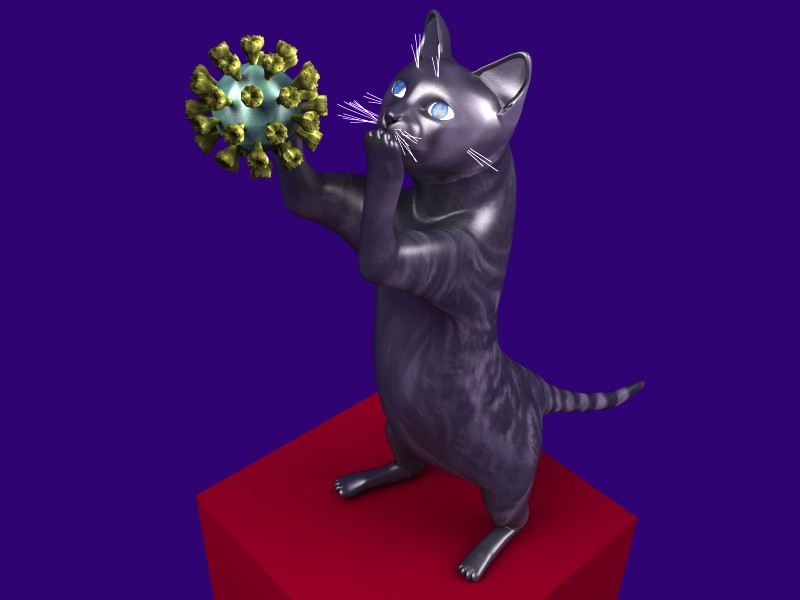

We try to implement a simple 1D CNN for forecasting. This method allow to quickly process in paralelle a great number of countries with very few tuning. [compotmental epidemiological model]https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology#The_SIR_model_with_vital_dynamics_and_constant_population have been and are part of the state of the art. Here we propose a very simple SIR model. It contains a compartment for Sicks, another for the Infectious who are the active cases and the Recovered. We should add a fourth compartment for deads to make a SIRD model, but i'll for another notebook. In the SIR model deads and recovered are in the same compartment, they are not anymore source of infection.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sb; sb.set()
import matplotlib.pyplot as plt
import random
from scipy.optimize import curve_fit
import scipy.integrate as spi

from keras.models import Sequential
from keras.layers import Dense, Flatten, GlobalMaxPooling1D, Dropout, GRU, BatchNormalization
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

# Some utility functions for data preparation
def upsample(country,df):
    """pad zeros before the onset of the outbreak for a given country"""
    df = df.loc[df.country==country]
    days = int((df.date.values[0]-start).astype('timedelta64[D]')/ np.timedelta64(1, 'D'))
    data = [[start+ np.timedelta64(i,'D'), country, 0, 0] for i in range(days)]
    return pd.DataFrame(data, columns=['date','country',target, 'duration_outbreak'])

def split_sequences(sequences, n_steps):
    """preparation of data with n_steps window predicting the next value"""
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
    X.append(seq_x)
    y.append(seq_y)
    return np.array(X), np.array(y)

### We are working with the covid_19_data.csv file

First cooutries name are cleaned in a 3 letters international code to allow a matching with data [world data bank](https://databank.worldbank.org/source/population-estimates-and-projections).

Then some extra-features are created:
* Actives are the current infectious
* duration_outbreak
* new cases are for incidence calculation
* prevalence are the sum of Confirmed since the beginning od the outbreak
* lethality is the proportion of confirmed people who die.
* log(Confirmed)

Lastly we select the countries with more than 15 days of outbreak and aggregate on date and country to get rid of regions.

In [ ]:
df = pd.read_csv('../input/novel-corona-virus-2019-dataset/covid_19_data.csv')

#load a mapping file to attribute international 3 lettres standard code to communicate with external data
df_map = pd.read_csv('../input/coronavirus/countryMapping.csv')
df = df.merge(df_map, how='left', on = 'Country/Region')
#transform data and create extra features
df['date'] = pd.to_datetime(df.ObservationDate)
df = df.loc[df.Confirmed>0]
df['Actives'] = df.apply(lambda x: x.Confirmed - x.Deaths - x.Recovered, axis = 1)
df.rename(columns= {'Country Code': 'country'}, inplace =True)
start = df.groupby('country').min().reset_index().rename(columns={'date':'start_outbreak'})[['country', 'start_outbreak']]
df = df.merge(start, on = 'country')
df['duration_outbreak'] = df.apply(lambda x: (x.date-x.start_outbreak).days, axis=1)
df_li = df[['date', 'country', 'Confirmed', 'Deaths', 'Recovered','Actives', 'duration_outbreak']]
#sum over regions of a same contry
df_li = df_li.groupby(['date','country']).agg({'Confirmed':'sum', 'Deaths':'sum', 'Recovered':'sum', 'Actives':'sum', 'duration_outbreak':'max'})
df_li.reset_index(inplace=True)

#select contries with more than 15 days of outbreak
lastDate = df[['date','country']].groupby('country').max().values[0][0]
sel = df.loc[df['date']== lastDate].groupby('country').max()
sel = sel.loc[sel.duration_outbreak > 15]
df_li = df_li.loc[df_li.country.isin(sel.index)]
print('%i countries'%df_li.country.unique().shape[0])
#create new features after aggregation and filtering
df_li['lethality'] = df_li.apply(lambda x: 100*x.Deaths / x.Confirmed , axis = 1)
#Convert cumulative Confirmed to new cases
newCases=[]
for cc in df_li.country.unique():
    cumul = df_li.loc[df_li.country==cc].sort_values('duration_outbreak').Confirmed.values
    newCases.extend([(cc, 0, cumul[0])] + [(cc, ix+1, i- cumul[ix]) for ix,i in enumerate(cumul[1:])])
newCases = pd.DataFrame(newCases, columns = ['country','duration_outbreak','new_cases'])
df_li = df_li.merge(newCases, on=['country','duration_outbreak'])
#Calculate prevalence from world bank population data
dfp = pd.read_csv('../input/coronavirus/world.csv')
wb_pop=  dfp.loc[dfp['Series Code'] == 'SP.POP.TOTL',['Country Code','2018 [YR2018]']]
wb_pop['2018 [YR2018]'] = wb_pop['2018 [YR2018]'].apply(lambda x: eval(x) if x !='..' else np.nan)
wb_pop = wb_pop.rename(columns={'2018 [YR2018]': 'population'})
df_li = df_li.merge(wb_pop, left_on = 'country', right_on='Country Code')
del df_li['Country Code']
df_li['prevalence'] = df_li.apply(lambda x: 10000*x.Confirmed/x.population, axis = 1)
df_li.dropna(inplace=True)
#basic variable transform
df_li['confirmed_log'] = df_li.Confirmed.apply(lambda x: np.log(x))
df_li.head()

### Now it's time to prepare data to be fit in the 1DCNN.

First data for each country are padded with zeros when outbreaks began after the start of the recording on 2020-01-22.

A filter to keep only countries with more than 200 cases allow to have meaningfull samples. 

A train set contains all records before 2020-03-07 and a test set contains the remaining records. There is no validation set for the training, because more days should be necessary in the dataset.

Lastly data are organized by arrays of 11 consecutive days of the studied variable, here the "confirmed_log", and the target is the next record on the 12th day. Each line contains the values for all studied countries i.e 50, so the shape is (nb_samples, 11,50) for the features and (nb_samples,1,50) for the target.


In [ ]:
#create dataset for 1DCNN
target = 'confirmed_log'
df_tar =  df_li[['date','country']+[target]].dropna()

#upsample for missing values before the onset of outbreak in a given country by padding 0
start = df_tar.loc[df_tar.country=='CHN'].date.values[0]
for cc in df_tar.country.unique():
    nsamp=upsample(cc, df_tar)
    df_tar = pd.concat([df_tar,nsamp], axis = 0, sort=False)
#Select countries with a significant number of cases    
countries = df_li.loc[df_li.Confirmed>200,'country'].unique()
sel = df_tar.loc[df_tar.country.isin(countries)].sort_values(['date','country'])
#make dataset compliant for 1DCNN inputs
sel = sel.pivot(index='date', columns='country', values=target)
#split on historic samples
train = sel[sel.index < '2020-03-07']
test = sel[sel.index >= '2020-03-07']
#slice the convolution window on 11 days
n_steps = 11
X,y = split_sequences(train.values,n_steps)
n_features = X.shape[2]
sel.head()

### Definition of a 1DCNN model.
This model is not optimal because no validation dataset was supplied during training. And probably a LSTM should perform better, but more data is probably required.

In [ ]:
# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(48, activation='relu'))
model.add(Dense(n_features))
model.compile(optimizer='adam', loss='mse')
model.summary()

#unsucessful tested layers:
#model.add(BatchNormalization())
#model.add(Dropout(0.2))
#model.add(GRU(64, dropout=0.1, recurrent_dropout=0.1))

### Let's run it

In [ ]:
# fit model
random.seed(3)
epochs=500
start_plot=0
history = model.fit(X, y, epochs=epochs, verbose=0)
loss = history.history['loss'][start_plot:]

#plot loss. Accuracy is not calculated because there is no validation set
start_plot=0
iepochs = range(start_plot,epochs)
plt.plot(iepochs, loss, 'bo', label='Training loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### Evaluation of the RMSE between prediction and test values for all countries

In [ ]:
def predict(n, previous=None):
    X_test = train.iloc[-n_steps+n:]
    if not previous is None:
        X_test = pd.concat([X_test, previous], axis = 0, sort=False)
    ref = test.iloc[n].values    
    X_test = X_test.values.reshape((1, n_steps, n_features))
    yhat = [int(round(i)) for i in model.predict(X_test, verbose=0)[0]]
    df =pd.DataFrame(list(zip(test.columns, yhat,ref)), columns = ['country','yhat','ref'])
    rmse = round(np.sqrt(np.mean((df.yhat.values-df.ref.values)**2)),2)
    del df['ref']
    df['date']=test.iloc[n:n+1].index.values[0]
    df = df.pivot(index='date', columns='country', values='yhat')
    if previous is None:
        previous = df
    else:
        previous = pd.concat([previous, df], axis=0, sort=False)
    return previous,rmse

rmses=[]
previous=None
for i in range(test.shape[0]): 
    previous,rmse = predict(i,previous)
    rmses.append(rmse)
                           
print ('rmse : %.2f'%np.mean(rmses))

### Let's see the result.
These are uneven results, particularly for Asia. It's interresting because the CNN could only infere from a period ending on 2020-02-26. From this period it predicts incease of prevalence. Since it appears the situation is better tha predicted, then the situation is improving. Remember we gave no guidance at all for the analysis. This is a lazzy supervised method.

In [ ]:
pred = pd.concat([train.iloc[-1:], previous], axis=0, sort=False)
x = pred.index.values.astype('datetime64[D]')
x=['-'.join(str(i).split('-')[1:]) for i in x]
xb = sel.index.values.astype('datetime64[D]')
xb=['-'.join(str(i).split('-')[1:]) for i in xb][-15:]

fig, axes = plt.subplots(ncols=4, nrows=6, figsize=(16,16))
for cc, ax in zip(test.columns, axes.flat):
    yb=list(sel[cc].values)[-15:]
    y=list(pred[cc].values)
    sb.lineplot(x=xb, y=yb, ax=ax).set_title(cc)
    sb.lineplot(x=x, y=y, ax=ax)
fig.tight_layout(h_pad=1, w_pad=0)

## The SIR method
Quick to implement but not easy to automate tunning of beta and gamma needs to be done by hand. A next step should be to use a better optimization procedure of the parameters of the SIR function, but this is not trivial to solve, because it's not convex for beta and gamma with discontinuous gradients.

In [ ]:
def diff_eqs(init,t):  
    y=np.zeros((3))
    v = init   
    y[0] = - beta * v[0] * v[1]
    y[1] = beta * v[0] * v[1] - gamma * v[1]
    y[2] = gamma * v[1]
    return y  
    
def SIR(x, *p):
    beta, gamma, amp, s0 ,i0 = p
    init = (s0, i0, 0.0)  
    res = spi.odeint(diff_eqs,init,x)
    return res[:,1]*amp

def fitted(y, p_initial):
    duration= y.shape[0]
    y = y/ np.linalg.norm(y)
    x = np.linspace(0, duration,duration)
    popt, pcov = curve_fit(SIR, x, y, p0=p_initial)
    print(popt)
    return (SIR(x, *popt), popt, x, y)    

### Case of China. The model is fitted to the known data and the model is extend to make prediction at 100 days.

In [ ]:
s0=1-1e-4      #initial p(succeptible)
i0=8e-3        #initial p(infectious)
beta = 0.3
gamma = 0.1
amp = 0.75
p_initial = [beta, gamma, amp,s0,i0]

sel = df_li.loc[df_li.country == 'CHN', 'Actives'].values  
yhat, popt, x, y = fitted(sel, p_initial)

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(8,4))
ax[0].plot(x,y, '-r', label='Infectious') 
ax[0].plot(yhat, '-b', label='Predicted')

yhat = SIR(range(0,100), *popt)    
ax[1].plot(yhat, '-b', label='Infectious')

### Case of Italy. The model extend to make prediction at 120 days.

In [ ]:
S0=1-1e-4      #initial p(succeptible)
I0=1e-5        #initial p(infectious)
INPUT = (S0, I0, 0.0)
beta = 0.43
gamma = 0.07
amp = 1.2
p_initial = [beta, gamma, amp,s0,i0]

sel = df_li.loc[df_li.country == 'ITA', 'Actives'].values  
yhat, popt, x, y = fitted(sel, p_initial)

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(8,4))
ax[0].plot(x,y, '-r', label='Infectious') 
ax[0].plot(yhat, '-b', label='Predicted')

yhat = SIR(range(0,120), *popt)    
ax[1].plot(yhat, '-b', label='Infectious')

## Conclusions

Probably a SIRD model should be included in the machine learning process, whatever it is.